In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import math
import itertools

#fx1 = lambda x1,x2,gamma:(x1**2 + x2 ** 2 * gamma)/2
pi = math.pi
def log(x):
    return math.log(x)
def cos(x):
    return math.cos(x)
def sin(x):
    return math.sin(x)
def exp(x):
    return np.exp(x)
def real(x):
    return np.real(x)
def imag(x):
    return np.imag(x)

E:\Users\bangu\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


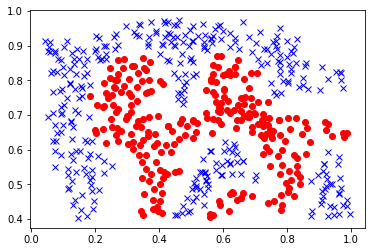

In [2]:
df = pd.read_csv("train_2d.txt", sep=',')
df_x = df[['x1','x2']]
df_y = df['y']
df_sub1 = df[df['y'] == 0]
df_sub2 = df[df['y'] == 1]
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')

In [64]:


def sigmoid(x,seta):
    #think x,seta as n * m - numpy array
    # x = n x m seta = m array
    # output as n*1 array
    
    return 1 / (1+ np.exp(-1*np.matmul(x,seta)))

def log_gradient(x,y,seta):
    # y = n *1
    z = np.matmul(sigmoid(x,seta)-y,x)
    return z/y.size

# using =X D X^T
# where X = x, D = diagonal matrix that has h(z)(1-h(z))
# ref = https://stats.stackexchange.com/questions/68391/hessian-of-logistic-function
def log_hessian(x,y,seta):
    #first step get diagonal mtx 
  
    m = y.size
    D = np.zeros((m,m))
    for i,x_i in enumerate(x):
        h = sigmoid(x_i, seta)
       # print(h)
        D[i][i] = h * (1-h)
    
   # print('------------------')
   # print(seta)
    #print('------------------')
    #print(D)
    # y = n *1
    #A = np.matmul(x,D)
    xt = np.transpose(x)
   
    H = np.matmul(np.matmul(xt,D),x)
    
    return H

class LogsitcRegression_custom_2ndDegree(object):
   
    def __init__(self,solver,itr, alpha):
        self.solver = solver
        self.itr = itr
        self.alpha = alpha
        
    def elimentWiseMul(self,x_, n):
        x_list = []
        for x_row in x_:
            x_val = x_row[0] * x_row[1]
            x_list.append(x_val)
        np_list = np.array(x_list)
        print(np_list.shape)
        
        return np_list.reshape([-1,1])
    def fit(self,x,y):        
        if self.solver == 'gradient':
            m = y.size
            n_datasize =  x.loc[0].size
            n = int(x.loc[0].size*2+n_datasize*(n_datasize-1)/2) + 1
            print(n)
            seta = np.zeros((n))
            ny = y.to_numpy()
            nx_2 = x.to_numpy()**2
            nx_12 = self.elimentWiseMul(x.to_numpy() ,n_datasize )
        #    print(x.to_numpy()[:,0], x.to_numpy()[:,1], nx_12)
            #print((np.zeros(m) + 1).shape)
            nx = np.hstack([np.ones(m).reshape(m,1),x.to_numpy(),nx_2,nx_12])
            #nx_
       #     print(nx)
            nx = nx/np.linalg.norm(nx, ord=2, axis=1, keepdims=True)
            
            for i in tqdm(range(1,self.itr),mininterval=1):

                #for j in range(1,m):
                z = nx.dot(seta)
                h = 1 / (np.exp((-1)* z) + 1)
                y_ = h
                y_check = np.rint(y_)
              #  print(y_check)
                distance = np.linalg.norm(ny-y_check,ord=1)
                if (i % 1000) == 1:
                    print((str((m-distance) / m * 100) + '% accuracy' )

                gdsum = np.zeros((n))
                for j in range (0,m):
                    for k in range (0,n): 
                        gdsum[k] += ((ny[j] - y_[j]) * nx[j][k]) / m

           #     print(seta)
                seta = seta + self.alpha * gdsum
            self.seta = seta
        elif self.solver == 'newton':
            m = x.df.shape[0]
            n = x.loc[0].size
            
            seta = np.zeros((n))
            ny = y.to_numpy()
            nx = x.to_numpy()
           # print(ny)
            for i in tqdm(range(1,self.itr),mininterval=1):
              
                G_ = log_gradient(nx,ny,seta)
                H_ = log_hessian(nx,ny,seta)
                H_inv = np.linalg.inv(H_)
              #  print(H_inv)
              #  print(G_)
                seta = seta - self.alpha * (np.matmul(H_inv , G_))
                if (i % 100) == 1:
                    z = nx.dot(seta)
                    h = 1 / (np.exp((-1)* z) + 1)
                    y_ = h
                    y_check = np.rint(y_)
                    distance = np.linalg.norm(ny-y_check,ord=1)
                    #sigmoid (x,seta)
                    print(str((m-distance) / m * 100) + '% accuracy' )

            self.seta = seta
       
    def predict (self,x):
        m = x.shape[0]
        n_datasize =  x.loc[0].size
        n = int(x.loc[0].size*2+n_datasize*(n_datasize-1)/2) + 1
     #   print(n)
        seta = np.zeros((n))
        #ny = y.to_numpy()
        nx_2 = x.to_numpy()**2
        nx_12 = self.elimentWiseMul(x.to_numpy() ,n_datasize )
      #  print(x.to_numpy()[:,0], x.to_numpy()[:,1], nx_12)
        #print((np.zeros(m) + 1).shape)
        nx = np.hstack([np.ones(m).reshape(m,1),x.to_numpy(),nx_2,nx_12])
     #   nx = x.to_numpy()
        z = nx.dot(self.seta)
        h = 1 / (np.exp((-1)* z) + 1)
        y_ = np.rint(h)
        return y_
    def getseta (self):
        return self.seta

SyntaxError: invalid syntax (<ipython-input-64-b108a5bee29b>, line 87)

In [72]:
lr = LogsitcRegression_custom_2ndDegree(solver = 'gradient', itr = 10000, alpha = 0.5)
lr.fit(df_x,df_y)
seta = lr.getseta()


#lr.custom

6
(578,)


43.59861591695502% accuracy
55.19031141868512% accuracy
55.36332179930796% accuracy
55.19031141868512% accuracy
56.57439446366782% accuracy
57.09342560553633% accuracy
57.266435986159166% accuracy
57.266435986159166% accuracy
57.61245674740484% accuracy
57.43944636678201% accuracy
57.95847750865052% accuracy
57.43944636678201% accuracy
57.95847750865052% accuracy
57.785467128027676% accuracy
57.61245674740484% accuracy
57.95847750865052% accuracy
57.785467128027676% accuracy
57.95847750865052% accuracy
57.95847750865052% accuracy
58.13148788927336% accuracy
58.82352941176471% accuracy
59.688581314878896% accuracy
60.034602076124564% accuracy
60.207612456747405% accuracy
61.245674740484425% accuracy
61.76470588235294% accuracy
62.80276816608996% accuracy
63.49480968858131% accuracy
64.53287197231833% accuracy
65.05190311418684% accuracy
65.91695501730104% accuracy
66.60899653979239% accuracy
67.1280276816609% accuracy
67.30103806228374% accuracy
67.64705882352942% accuracy
68.1660899653

(578,)


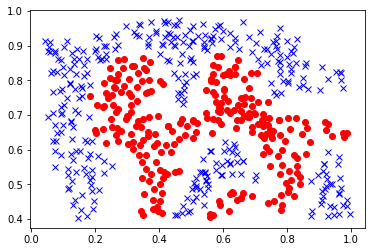

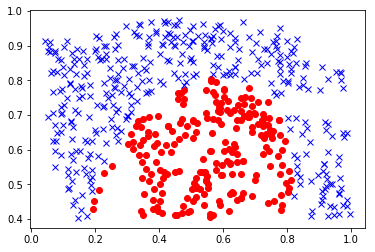

In [66]:
predicited_y = lr.predict(df_x)

df_trained_2nd_logistic = pd.concat([df_x,  pd.DataFrame(predicited_y,columns=['y'])], axis=1)

plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')
#drawx1 =  np.linspace(0, 1, 100)
#s0 + x1 s1 + x2 s2 = 0 인점은
# x2 = (-s0 - s1) x1  / s2
#drawx2 = (-seta[0] - seta[1] * drawx1) / seta[2]
#for i,x1 in enumerate(drawx1):
#plt.plot(drawx1,drawx2)

plt.figure()
df_sub11 = df_trained_2nd_logistic[df_trained_2nd_logistic['y'] == 0]
df_sub22 = df_trained_2nd_logistic[df_trained_2nd_logistic['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')


In [33]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(df_x, df_y)
#clf.score(df_x, df_y)

In [28]:
class NaiveBayesClassifier_cont_input:
    def __init__(self, k=0.5,method = 'g-distribution'):
        self.k = k
        self.word_probs = []
        self.method = 'g-distribution'
    def fit(self, x,y):
        xy = pd.concat([x, y], axis=1)
        #print(xy)
        if self.method == 'g-distribution':
            #x1, x2 ... 에 대해서 가우시안 분포를 만든다.
            m = y.size
            n = x.loc[0].size       
            self.n = n
            ny = y.to_numpy()
            nx = x.to_numpy()
            fx_list = []
            mean_y0_list = []
            mean_y1_list = []
            var_y0_list = []
            var_y1_list = []
            for i in range (0,n):
                xy_0 = xy[xy['y'] == 0]
                xy_1 = xy[xy['y'] == 1]
                self.py1 = xy_0.shape[0]
                self.py2 = xy_1.shape[0]
                
                nx_y0_mean = xy_0.iloc[:,i].mean()
                nx_y0_var = xy_0.iloc[:,i].var()
                nx_y1_mean = xy_1.iloc[:,i].mean()
                nx_y1_var = xy_1.iloc[:,i].var()                
                
                mean_y0_list.append(nx_y0_mean)
                var_y0_list.append(nx_y0_var)
                
                mean_y1_list.append(nx_y1_mean)
                var_y1_list.append(nx_y1_var)
                
             #   print(nx_y0_mean,nx_y0_var)
             #   print(nx_y1_mean,nx_y1_var)
                fx1 = lambda x__ : (2* pi * nx_y0_var) ** (-0.5) * exp( -((x__-nx_y0_mean)** 2) /  (2 * nx_y0_var))
                fx2 = lambda x__ : (2* pi * nx_y1_var) ** (-0.5) * exp( -((x__-nx_y1_mean)** 2) /  (2 * nx_y1_var) )                                                    
                fx_list.append((fx1,fx2))
            self.mean_y0_list = mean_y0_list
            self.mean_y1_list = mean_y1_list
            self.var_y0_list = var_y0_list
            self.var_y1_list = var_y1_list
            self.gaussians = fx_list
    def classify(self, x):
        if self.method == 'g-distribution':
            mul1 = 1
            mul2 = 1
            for i in range (0,self.n):
                (fx1,fx2) = self.gaussians[i]
                #print( x[i] , fx1(x[i]))
                mul1 = mul1 * fx1(x[i]) 
                mul2 = mul2 * fx2(x[i])
                #print(mul1,mul2)
            summer = mul2 / (mul1+ mul2)
           # print ('finall prob = ' +str(summer))
            return summer
    def modify_moveval(self,idx,mean,val,y_0):
        if y_0 == 0:
            self.mean_y0_list[idx] += mean
            self.var_y0_list[idx] += val
            fx1,fx2 = self.gaussians[idx]
            fx1 = lambda x__ : (2* pi * self.var_y0_list[idx]) ** (-0.5) * exp( -((x__- self.mean_y0_list[idx])** 2) /  (2 * self.var_y0_list[idx]))
            self.gaussians[idx] = (fx1,fx2)
        if y_0 == 1:
            self.mean_y1_list[idx] += mean
            self.var_y1_list[idx] += val
            fx1,fx2 = self.gaussians[idx]
            fx2 = lambda x__ : (2* pi * self.var_y1_list[idx]) ** (-0.5) * exp( -((x__- self.mean_y1_list[idx])** 2) /  (2 * self.var_y1_list[idx]))
            self.gaussians[idx] = (fx1,fx2)

In [45]:
NB = NaiveBayesClassifier_cont_input(k = '0.5', method = 'g-distribution')
NB.fit(df_x,df_y)
NB.modify_moveval( 0,(0.2),(0.01),1 )
NB.modify_moveval( 0,(0.1),(0),0 )
r_y = []
for index, xx in df_x.iterrows():
  #  print(xx)
   # print(xx[0])
    prob1 = NB.classify(xx)
    if prob1 >= 0.5:
        r_y.append (1)
    else:
        r_y.append (0)

df_ry = pd.DataFrame(r_y,columns=['y'])
df_trained_mv2 = pd.concat([df_x, df_ry], axis=1)
#df_trained = df_x.append(r_y)

0.6868512110726643


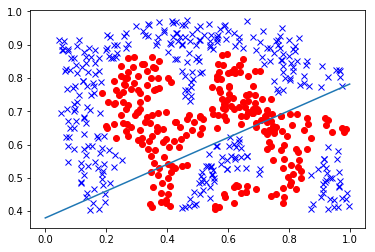

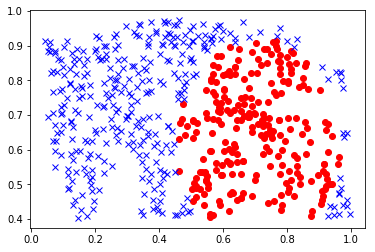

In [36]:
count_right=0
count_wrong=0
for index, xy in df_trained.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
#df_trained

df_ry = pd.DataFrame(r_y,columns=['y'])
df_trained = pd.concat([df_x, df_ry], axis=1)
drawx1 =  np.linspace(0, 1, 100)
df_sub1 = df[df['y'] == 0]
df_sub2 = df[df['y'] == 1]
plt.plot(df_sub1['x1'],df_sub1['x2'],'ro')
plt.plot(df_sub2['x1'],df_sub2['x2'],'bx')
drawx2 = (-seta[0] - seta[1] * drawx1) / seta[2]
#for i,x1 in enumerate(drawx1):
plt.plot(drawx1,drawx2)

plt.figure()
df_sub11 = df_trained[df_trained['y'] == 0]
df_sub22 = df_trained[df_trained['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')

0.629757785467128


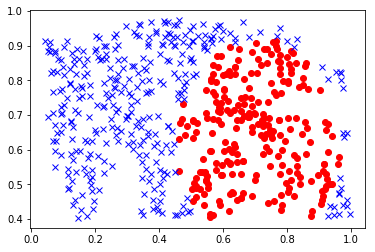

In [35]:
count_right=0
count_wrong=0
for index, xy in df_trained_mv1.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
plt.figure()
df_sub11 = df_trained_mv1[df_trained_mv1['y'] == 0]
df_sub22 = df_trained_mv1[df_trained_mv1['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')

0.7664359861591695


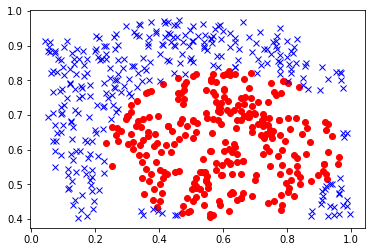

In [46]:
count_right=0
count_wrong=0
for index, xy in df_trained_mv2.iterrows():
    if xy['y'] == df.iloc[index]['y']:
        count_right+=1
    else :
        count_wrong+=1
        
print(count_right/(count_right+count_wrong))
plt.figure()
df_sub11 = df_trained_mv2[df_trained_mv2['y'] == 0]
df_sub22 = df_trained_mv2[df_trained_mv2['y'] == 1]
plt.plot(df_sub11['x1'],df_sub11['x2'],'ro')
plt.plot(df_sub22['x1'],df_sub22['x2'],'bx')